In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [ ]:
# Define training parameters
input_dim = 784
label_dim = 10
latent_dim = 2
batch_size = 128
epochs = 50
lr = 0.001

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 72778709.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 113422934.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25583333.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22706232.14it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

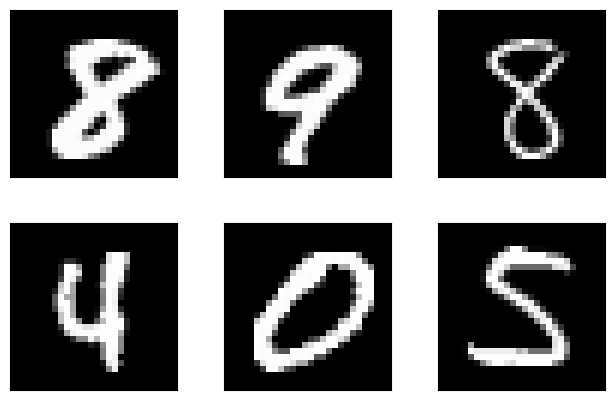

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [ ]:
# Define the Conditional Variational Autoencoder (CVAE) architecture
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + label_dim, 256),
            nn.ReLU(),
        )
        self.z_mean = nn.Linear(256, latent_dim)
        self.z_log_var = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, x, labels):
        merged_input = torch.cat((x, labels), dim=1)
        encoder_output = self.encoder(merged_input)
        z_mean = self.z_mean(encoder_output)
        z_log_var = self.z_log_var(encoder_output)
        z = self.reparameterize(z_mean, z_log_var)

        merged_decoder_input = torch.cat((z, labels), dim=1)
        decoded = self.decoder(merged_decoder_input)
        return decoded, z_mean, z_log_var

In [ ]:
# Loss function
def vae_loss(recon_x, x, z_mean, z_log_var):
    reconstruction_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return reconstruction_loss + kl_divergence

In [ ]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the CVAE model and optimizer
cvae = CVAE(input_dim, label_dim, latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=lr)

In [ ]:
# Train the model
loss_list = []
cvae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        labels = labels.to(device)
        labels_onehot = torch.zeros(labels.size(0), label_dim).to(device)
        labels_onehot.scatter_(1, labels.view(-1, 1), 1)


        optimizer.zero_grad()
        recon_data, z_mean, z_log_var = cvae(data, labels_onehot)
        loss = vae_loss(recon_data, data, z_mean, z_log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    loss_list.append(total_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader.dataset):.4f}')

Epoch [1/50], Loss: 187.7242
Epoch [2/50], Loss: 148.8173
Epoch [3/50], Loss: 142.5266
Epoch [4/50], Loss: 139.9047
Epoch [5/50], Loss: 138.2576
Epoch [6/50], Loss: 137.1090
Epoch [7/50], Loss: 136.2840
Epoch [8/50], Loss: 135.6365
Epoch [9/50], Loss: 135.1368
Epoch [10/50], Loss: 134.6625
Epoch [11/50], Loss: 134.3104
Epoch [12/50], Loss: 134.0219
Epoch [13/50], Loss: 133.7207
Epoch [14/50], Loss: 133.4645
Epoch [15/50], Loss: 133.2659
Epoch [16/50], Loss: 133.0330
Epoch [17/50], Loss: 132.8788
Epoch [18/50], Loss: 132.6964
Epoch [19/50], Loss: 132.5276
Epoch [20/50], Loss: 132.3861
Epoch [21/50], Loss: 132.2413
Epoch [22/50], Loss: 132.0948
Epoch [23/50], Loss: 131.9739
Epoch [24/50], Loss: 131.8781
Epoch [25/50], Loss: 131.7499
Epoch [26/50], Loss: 131.6685
Epoch [27/50], Loss: 131.5395
Epoch [28/50], Loss: 131.4485
Epoch [29/50], Loss: 131.3547
Epoch [30/50], Loss: 131.2629
Epoch [31/50], Loss: 131.1832
Epoch [32/50], Loss: 131.1282
Epoch [33/50], Loss: 131.0296
Epoch [34/50], Loss

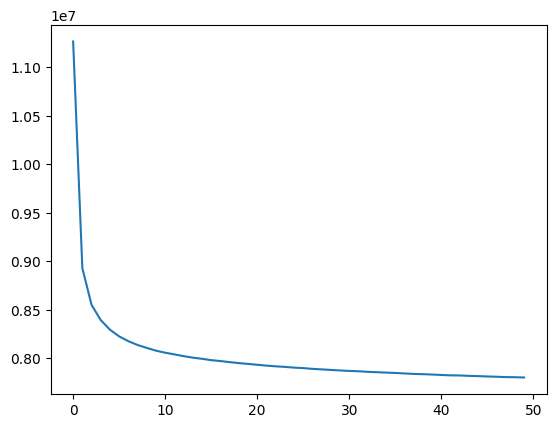

In [ ]:
plt.plot(loss_list)

In [ ]:
# Generate samples from the CVAE
def generate_samples(n_samples, label):
    random_latent = torch.randn(n_samples, latent_dim)
    label_input = torch.zeros(n_samples, label_dim)
    label_input[:, label] = 1
    generated_images = cvae.decoder(torch.cat((random_latent, label_input), dim=1).to(device))
    generated_images = generated_images.view(-1, 28, 28).detach().cpu().numpy()
    return generated_images

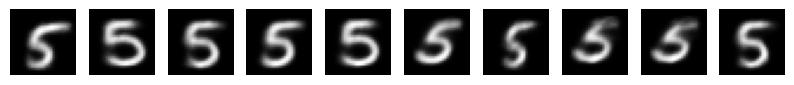

In [ ]:
label_to_generate = 5  # Change this to the desired label
generated_samples = generate_samples(10, label_to_generate)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_samples[i], cmap='gray')
    plt.axis('off')
plt.show()